# Proteomics Analysis Tool
 
## Variables
trial_number (int): number of trials per variant per media \
fold_change_threshold (float): fold change threshold (for +- significance) \
\
quantitative (bool): use threshold to determine if measurements in a media are significant (set value to 'False' if qualitative) \
quantitative_threshold (float): threshold for determining significant measurements \
\
start_path (str): location of Excel files (relative to ipynb kernel directory)\
end_path (str): location of output Excel files and figures (relative to ipynb kernel directory)

In [10]:
# base settings
trial_number=3
fold_change_threshold=0.5

# quantitative analysis settings
quantitative=True
quantitative_threshold=5

# start and end path (default value when empty is base ipynb kernel directory)
start_path = ''
end_path = ''

# verbose debug (currently only outlier output)
verbose = False

## Setup

In [11]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [12]:
# Helper function: create random floats
def random_float(mean, std, seed=""):
    rng = np.random.default_rng() if not seed else np.random.default_rng(seed=seed)
    return rng.uniform(low=mean-std, high=mean+std)

# Helper function: define whether row is an outlier (input is 6-value list, first 3 num, last 3 den)
def is_outlier(row):
    num = row[:3]
    den = row[3:]
    num.sort()
    den.sort()
        
    #num check
    if num[0] < np.mean(num[1:]) - quantitative_threshold or num[-1] > np.mean(num[:-1]) + quantitative_threshold:
        if verbose:
            print("Outlier found in numerator:", num)
        return True
    
    #den check
    if den[0] < np.mean(den[1:]) - quantitative_threshold or den[-1] > np.mean(den[:-1]) + quantitative_threshold:
        if verbose:
            print("Outlier found in denominator:", den)
        return True
    
    return False

In [13]:
def analyze(data_sheet: str, d: str, n: list):
    # read excel file
    xl = pd.read_excel(start_path + data_sheet, sheet_name="edited")
    xl = np.vstack((list(xl), xl.to_numpy()))

    # set denom data
    d_col = []
    for i in range(2, len(xl[0])):
        if d == xl[0][i][: (xl[0][i].index("_") if "_" in xl[0][i] else xl[0][i].index("-"))]:
            d_col.append(i)

    if len(d_col) != trial_number:
        print("Count for", d, "is not 3, please check inputs and data sheets again")
        return
    d_col = xl[:, d_col]

    # set numers data
    n_cols = {}
    for x in n:
        n_col = []
        for i in range(2, len(xl[0])):
            if x == xl[0][i][: (xl[0][i].index("_") if "_" in xl[0][i] else xl[0][i].index("-"))]:
                n_col.append(i)
        if len(n_col) != trial_number:
            print("Count for", x,
                  "is not 3, please check inputs and data sheets again")
            return
        n_cols[x] = xl[:, n_col]

    # do analysis
    analyzed = {}
    for x in n_cols:
        n_col = n_cols[x]
        total = np.hstack(
            (xl[:, 0].reshape(-1, 1), xl[:, 1].reshape(-1, 1), d_col, n_col))

        total_delete_row = []
        for i in range(2, len(total)):
            if total[i][2:].sum() == 0 or (quantitative and (total[i][2:] > quantitative_threshold).sum() < 3) or is_outlier(total[i][2:]):
                total_delete_row.append(i)

        tf = np.delete(total, total_delete_row, axis=0)

        calc = tf[2:, 2:].flatten()[tf[2:, 2:].flatten() < (
            quantitative_threshold if quantitative else 1)]
        if (sum(calc) == 0):
            # what should I do when there are no values less than 1 but are just all 0's?
            calc, mean, std = 0, 0, 0
        else:
            calc = calc[calc > 0]
            mean = np.mean(calc)
            std = np.std(calc)

        for i in range(1, len(tf)):
            for j in range(1, len(tf[0])):
                if tf[i][j] == 0:
                    tf[i][j] = random_float(mean, std)
                    tf[i][1] += ("*" if "*" not in tf[i][1] else "")

        l2fc = ["L2FC"]
        nl10pv = ["-log10(p-value)"]
        sig = [" "]

        up = []
        down = []
        rest = []
        for i in range(1, len(tf)):
            num = tf[i][5:8]
            den = tf[i][2:5]
            l2fc.append(np.log2(np.mean(num) / np.mean(den)))
            nl10pv.append(-1 * np.log10(scipy.stats.ttest_ind(num,
                          den, equal_var=False)[1])),
            if l2fc[-1] > fold_change_threshold and nl10pv[-1] > 1.30102999566:
                sig.append("UP")
                up.append([l2fc[-1], nl10pv[-1]])
            elif l2fc[-1] < -1 * fold_change_threshold and nl10pv[-1] > 1.30102999566:
                sig.append("DOWN")
                down.append([l2fc[-1], nl10pv[-1]])
            else:
                sig.append(" ")
                rest.append([l2fc[-1], nl10pv[-1]])

        l2fc_std = ['L2FC_STD']
        av = np.average(l2fc[1:])
        std = np.std(l2fc[1:])
        for fc in l2fc[1:]:
            fc_std = (fc - av) / std
            l2fc_std.append(fc_std)
        
        up_scatter = plt.scatter([i[0] for i in up], [i[1]
                                 for i in up], c="blue")
        down_scatter = plt.scatter([i[0] for i in down], [
                                   i[1] for i in down], c="red")
        r = plt.scatter([i[0] for i in rest], [i[1] for i in rest], c="grey")
        plt.legend((up_scatter, down_scatter),
                   ("Up Regulated", "Down Regulated"))
        plt.title(d + " vs " + x)
        plt.xlabel("Log2 Fold Change")
        plt.ylabel("-Log10 P-Value")

        if not os.path.isdir(end_path + "figures"):
            os.makedirs(end_path + "figures")
        plt.savefig(end_path +
                    "figures/" + data_sheet[:data_sheet.index(".")] + "_" + d + "_VS_" + x + ".png")

        tf = np.hstack((tf, np.array(l2fc).reshape(-1, 1),
                       np.array(nl10pv).reshape(-1, 1), np.array(l2fc_std).reshape(-1, 1), np.array(sig).reshape(-1, 1)))

        analyzed[x] = pd.DataFrame(tf)
        
    # write to excel
    writer = pd.ExcelWriter(
        end_path + data_sheet[:data_sheet.index(".xlsx")] + "_" + n[0] + ".xlsx", engine="xlsxwriter")
    for sheet in analyzed:
        analyzed[sheet].to_excel(
            writer, sheet_name=sheet, index=False, header=False)
    writer.save()

In [14]:
def prot(data_sheets, d, n):
    for data_sheet in data_sheets:
        analyze(data_sheet, d, n)

## Run

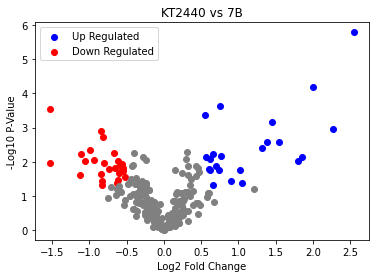

In [15]:
# excel file names (for multiple: ['media1.xlsx', 'media2.xlsx', 'media3.xlsx'])
data_sheets = ['HBA.xlsx']
# denominator
d = 'KT2440'
# numerators/tabs (for multiple: ['1B', '2B', '3B'])
n = ['7B']

prot(data_sheets, d, n)